In [ ]:
! pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from PIL import UnidentifiedImageError
from tensorflow.keras.metrics import Precision
from tensorflow.keras.layers import BatchNormalization

In [24]:
class ImageDataset:
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.images = []
        self.labels = []

    def load_data(self):
        """Carga las imágenes y asigna las etiquetas correspondientes."""
        for label in ['plaga', 'sana']:
            label_dir = os.path.join(self.data_dir, label) #Construye la ruta a la carpeta de la etiqueta
            for image_name in os.listdir(label_dir): #Itera sobre las imágenes en la carpeta de la etiqueta
                img_path = os.path.join(label_dir, image_name) #Construye la ruta completa a la imagen
                img_array = self.load_and_preprocess_image(img_path) #Carga y preprocesa la imagen
                if img_array is not None: #Verifica si la imagen se cargó correctamente
                    self.images.append(img_array) #Agrega la imagen a la lista de imágenes
                    self.labels.append(self.assign_label(label)) #Asigna la etiqueta binaria y la agrega a la lista de etiquetas

    def load_and_preprocess_image(self, img_path): 
        """Carga y preprocesa cada imagen."""
        try:
            img = load_img(img_path, target_size=(224, 224))  # Redimensionar a 224x224
            img_array = img_to_array(img) / 255.0  # Normalizar a [0, 1]
            return img_array # Devuelve el array de la imagen
        except (UnidentifiedImageError, OSError) as e: # Manejo de errores para imágenes no válidas
            print(f"Error al cargar la imagen {img_path}: {e}") # Imprime el error
            return None # Devuelve None si hay un error

    def assign_label(self, label): 
        """Asigna una etiqueta binaria a las imágenes."""
        return 1 if label == 'plaga' else 0 # Asigna 1 para 'plaga' y 0 para 'sana'

Precision se usa para evitar falsos positivos lo cual nos ayudara aca

In [26]:
class CNNModel:
    def __init__(self):
        """Crea la arquitectura del modelo."""
        self.model = models.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
            #BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(512, activation='relu'),
            layers.Dropout(0.4),
            layers.Dense(1, activation='sigmoid')  # Salida binaria (plaga o sana)
        ])

    def compile(self):
        """Compila el modelo."""
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision()])

    def train(self, X_train, y_train, X_val, y_val, epochs=6, batch_size=32):
        """Entrena el modelo sin Data Augmentation."""
        
        early_stopping = EarlyStopping(
                monitor='val_loss',      # Monitorear la pérdida de validación
                patience=3,              # Número de épocas sin mejora antes de detener el entrenamiento
                restore_best_weights=True, # Restaurar los pesos del modelo al valor de la mejor época
                verbose=1                # Imprimir mensajes cuando el entrenamiento se detenga
            )
        history = self.model.fit(X_train, y_train, 
                                 epochs=epochs, 
                                 batch_size=batch_size, 
                                 validation_data=(X_val, y_val), 
                                 callbacks=[early_stopping],
                                 verbose=1)
        return history

    def evaluate(self, X_val, y_val):
        """Evalúa el modelo con los datos de validación."""
        loss, accuracy, precision = self.model.evaluate(X_val, y_val)
        print(f'Pérdida: {loss}, Accuracy: {accuracy}, Precisión (métrica): {precision}')
        return loss, accuracy, precision

    def save(self, model_name='modelo_entrenado.h5'):
        """Guarda el modelo entrenado."""
        self.model.save(model_name)

In [27]:
data_dir = 'data/'  # Reemplázalo por la ruta de tu carpeta de imágenes
dataset = ImageDataset(data_dir)
dataset.load_data()

# Convertir las listas a arrays de NumPy
images = np.array(dataset.images)
labels = np.array(dataset.labels)

# Dividir las imágenes en entrenamiento (80%) y validación (20%)
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Crear instancias de los generadores de datos con aumento de datos
#data_augmentation = DataAugmentation()
#train_generator = data_augmentation.get_train_generator(X_train, y_train)
#val_generator = data_augmentation.get_val_generator(X_val, y_val)

# Crear y entrenar el modelo
model = CNNModel()
model.compile()
history = model.train(X_train, y_train, X_val, y_val, epochs=50)

# Evaluar el modelo
loss, accuracy, precision = model.evaluate(X_val, y_val)

# Guardar el modelo entrenado
model.save()

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.4451 - loss: 2.9989 - precision_5: 0.4429 - val_accuracy: 0.4750 - val_loss: 0.7882 - val_precision_5: 0.0000e+00
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5546 - loss: 0.6697 - precision_5: 0.5000 - val_accuracy: 0.5250 - val_loss: 0.7075 - val_precision_5: 0.5250
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6411 - loss: 0.6227 - precision_5: 0.6191 - val_accuracy: 0.7000 - val_loss: 0.5984 - val_precision_5: 0.8000
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7448 - loss: 0.5054 - precision_5: 0.7759 - val_accuracy: 0.7250 - val_loss: 0.6141 - val_precision_5: 0.6667
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8071 - loss: 0.4323 - precision_5: 0.7599 - val_accuracy: 0.8000 - val_loss: 0.4882 - val_precision_5: 0.7407
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8493 - loss: 0.3435 - precision_5: 0.8189 - val_accuracy: 0.7500 - val_loss: 0.

Pérdida: 0.48821431398391724, Accuracy: 0.800000011920929, Precisión (métrica): 0.7407407164573669


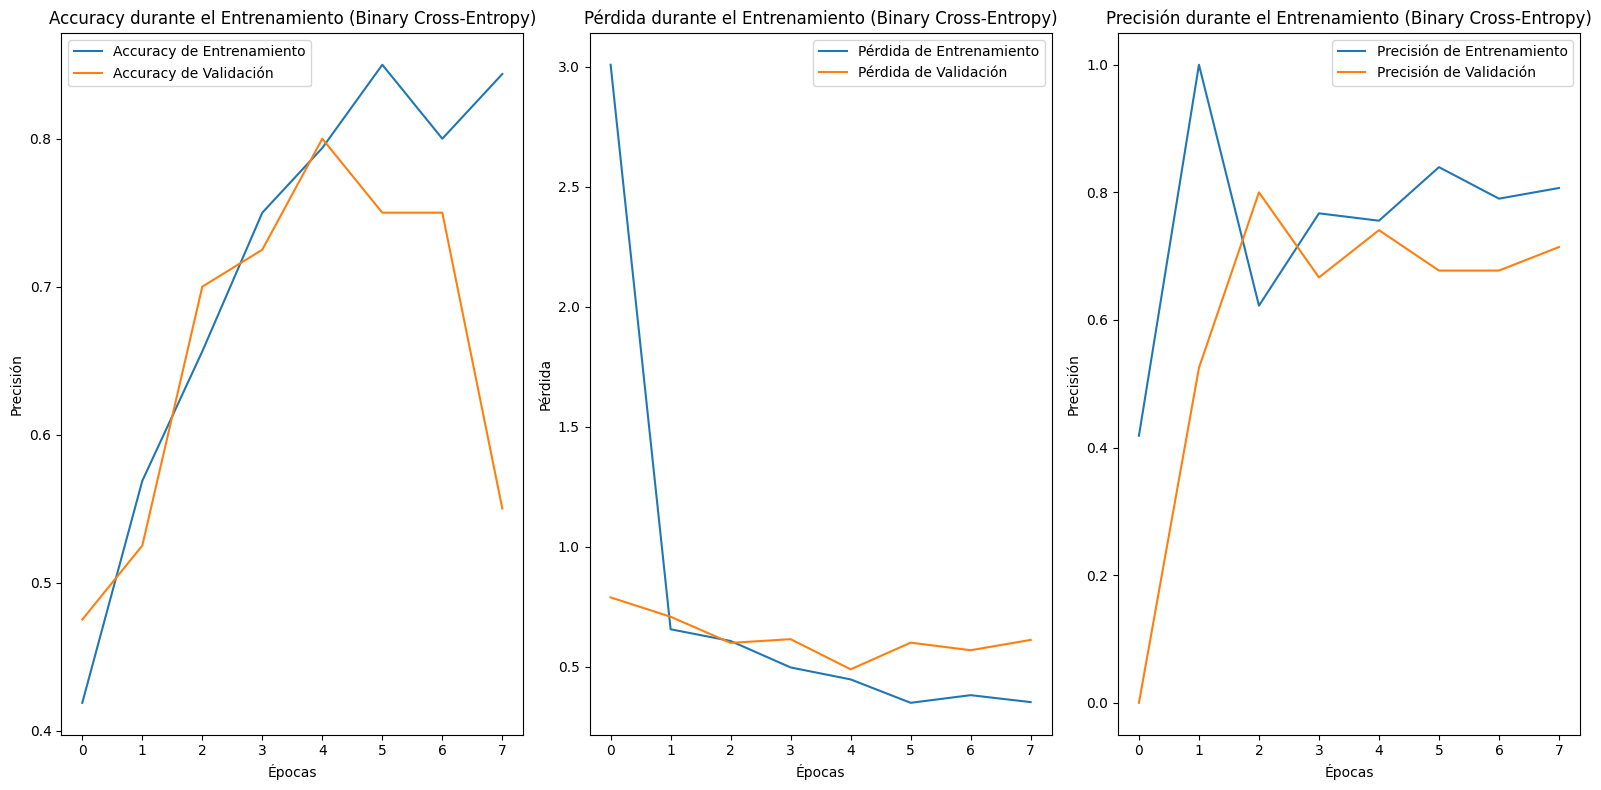

In [28]:
def plot_training_history(history, loss_name):
    # Graficar la evolución de la precisión durante el entrenamiento
    plt.figure(figsize=(16, 8))

    # Precisión de entrenamiento
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Accuracy de Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Accuracy de Validación')
    plt.title(f'Accuracy durante el Entrenamiento ({loss_name})')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()

    # Pérdida durante el entrenamiento
    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida de Validación')
    plt.title(f'Pérdida durante el Entrenamiento ({loss_name})')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    # Precisión durante el entrenamiento
    plt.subplot(1, 3, 3)
    plt.plot(history.history['precision_5'], label='Precisión de Entrenamiento')
    plt.plot(history.history['val_precision_5'], label='Precisión de Validación')
    plt.title(f'Precisión durante el Entrenamiento ({loss_name})')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Graficar el historial de entrenamiento
plot_training_history(history, "Binary Cross-Entropy")


In [ ]:
model.save('modelo_entrenado.h5')